In [2]:
%%bash
pip install --upgrade mxnet gluoncv
# optional - for displaying the image in notebook
pip install ipyplot
# After you run this cell, you need to restart
# the notebook

  Using cached mxnet-1.7.0.post1-py2.py3-none-manylinux2014_x86_64.whl (55.0 MB)
  Using cached gluoncv-0.8.0-py2.py3-none-any.whl (810 kB)
  Using cached portalocker-2.0.0-py2.py3-none-any.whl (11 kB)
  Using cached ipyplot-1.0.5-py3-none-any.whl (6.3 kB)


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
import mxnet as mx
import gluoncv as gcv
# class method for displaying images
import matplotlib.pyplot as plt
gcv.utils.check_version('0.6.0')


In [2]:
image = mx.image.image.imread('mt_baker.jpg')

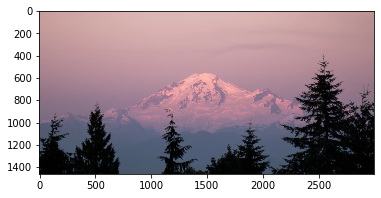

In [3]:
plt.imshow(image.asnumpy())

In [4]:
# this is in HWC layout.
# hieght is first dimenision
# width is the second
# channel is the third
# 
# the values are unsigned 8-bit integers.  The channel is encoded as RGB
print(image[0][0])


[199 158 156]
<NDArray 3 @cpu(0)>


# Need to convert numpy array into form for use with gluon 

The mxnet network expects multiple dimensions as a batch so it needs an extrad dimension.

The error message which arises when this happens  is 

```
 data.ndim() = 4U (3 vs. 4)
 input data should be 4D in batch-num_filter-y-x
```

Array Notes

* y and x = height and width
* N=batch
* C=channel
* H=Height
* W=width

Also,

* gluon expects 32-bit floats
* data is 0-255 unsigned bytes

Data shoukd be avg value 0f zero and standard deviayon of 1

For example `[-1 to 1]`

gluoncv has a transform program for converting it


In [5]:
print('shape: ', image.shape)
print('data types:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape:  (1458, 3000, 3)
data types: <class 'numpy.uint8'>
minimum value: 0
maximum value: 255


In [6]:
image = gcv.data.transforms.presets.imagenet.transform_eval(image)

In [7]:
print('shape: ', image.shape)
print('data types:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape:  (1, 3, 224, 224)
data types: <class 'numpy.float32'>
minimum value: -2.117904
maximum value: 2.2489083


# Image transform notes
* image is cropped and scaled to 224x224 in center  of image

# Load Model
specify the model name
and specify it as pretrained
The cache will load the model parameters from our earlier run.

Alternatively you can load the model directly

In [8]:
network = gcv.model_zoo.get_model('ResNet50_v1d', pretrained=True)

In [9]:
# Alternate model load method
# you can use TAB for jupyter to list available models
network = gcv.model_zoo.resnet50_v1d(pretrained=True)

# Make prediction
Input was a batch of images.
Output is a batch of predictions

In [13]:
prediction = network(image)

In [14]:
print(prediction.shape)

(1, 1000)


In [15]:
prediction = prediction[0]
print(prediction.shape)

(1000,)


When we look at a sample of the predictions, we just see numbers.  These are raw values which are outputs of the network and sometimes called logits.

In [16]:
print('Skipping 975 values...')
print(prediction[975:])

Skipping 975 values...

[ 4.34455     2.1889205   1.2312093   2.3473244   4.574925    9.468042
 -0.30540988 -0.6476072  -0.52499914  0.93352157  0.7344682   0.633968
  0.08522959  0.49712706  0.47199595  0.688145    0.5201411   0.4817186
  1.0798144   1.253247    0.89670455 -0.433789    0.6877534   0.70875657
  0.7740851 ]
<NDArray 25 @cpu(0)>


Convert logits to probabilites

In [17]:
probability = mx.nd.softmax(prediction)

In [18]:
rounded_probability = mx.nd.round(probability * 100) / 100
print('Skipping 975 values...')
print(rounded_probability[950:])

Skipping 975 values...

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.05 0.   0.   0.   0.   0.   0.   0.
 0.   0.01 0.83 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 50 @cpu(0)>


Most classes have a predicted probability of zero.  One class has a high probability, which is 0.83

For an explantion of how these values were converted to probability via the softmax function check my notes with apple pencil.  

### summary
* set of logits converted to set of probabilities.
* probabilities sum to 1
* increasing one value will increase probability of that value and decrease others.
* reverse is likewise

In [19]:
mx.nd.softmax(mx.nd.array((-0.5,0.5)))


[0.26894143 0.73105854]
<NDArray 2 @cpu(0)>

In [20]:
mx.nd.softmax(mx.nd.array((-0.5,1.0)))


[0.18242553 0.8175745 ]
<NDArray 2 @cpu(0)>

In [21]:
mx.nd.softmax(mx.nd.array((-1.0,1.0)))


[0.11920291 0.880797  ]
<NDArray 2 @cpu(0)>

# Get top-k
Since we have a large number of classes, lets use the top-k function to get the top 3 predicited classes by
probability

In [22]:
k=3
topk_indicies = mx.nd.topk(probability, k=k)
topk_indicies


[980. 970. 979.]
<NDArray 3 @cpu(0)>

Class index 980 is the most likely since these are sorted.  We could apply the top-k to the array since the softmax function
does not sort the array when it does its conversion.

# Get class labels
The network has the labels. 567 corresponds to frying pan

In [23]:
network.classes[567]

'frying pan'

# Final Answers
asscalar converts an mxnet array of 1d, into a python literal

In [24]:
for i in range(k):
    class_index = topk_indicies[i].astype('int').asscalar()
    class_label = network.classes[class_index]
    class_probability = probability[class_index]
    print('#{} {} ({:0.3}%)' . format(i+1, class_label, class_probability.asscalar()*100))

#1 volcano (83.2%)
#2 alp (5.06%)
#3 valley (0.624%)
